# Gain scheduling and Auto tuning
In this notebook the topic of gain scheduling is studied.

## Preparation
The only prerequisite for the lab is tha you have read Chapter 9 in "Adaptive Control" by K.J. Astrom. If you do not have this book, we recommend that you read chapter 9 in the book
"The electrical engineering handbook" av C. J. Bett, available [here](https://www.sciencedirect.com/science/article/pii/B9780121709600500864) through Sience Direct.

## The processes
The processes studied in this laboratory session are third order systems with two poles in $s=-0.5$ and one pole in -2,
$$P(s) = \dfrac{1}{(2s+1)^2(0.5s+1)}.$$
In the first part of the lab, we will control this processs using P and PID-controllers, comparing a manual tuning with Zeigler Nichol's method. In the second part exercise, we will instead use nonlinear optimization to compute optimize the controller parameters subject to a set of frequency domain contsraints. In the third part, we will add an inputnonlinearity, and use gain scheduling to achieve good time-domain performance.


## Installation
First of all, you need Julia installed, see https://julialang.org/downloads/. You also need [IJulia](https://github.com/JuliaLang/IJulia.jl#installation), which in turn requires Jupyter. On the Lab computers, Julia 1.0.3 will be pre installed, so you just need to follow the five steps below:

[1] In the terminal, execute the following.

```
cd && git clone https://github.com/JuliaControl/ControlExamples.jl
cd ControlExamples.jl
mkdir /var/tmp/$USER
export JULIA_DEPOT_PATH=/var/tmp/$USER
```

[2] Open Julia and install the necessary packages by running
```
julia
using Pkg
``` 
[3] In the Julia prompt, enter the package manager by writing ], and then
```
dev ControlSystems GR Interact IJulia
dev OrdinaryDiffEq Plots ForwardDiff NLopt Roots
precompile
``` 
[4] Next, while still being in the Julia prompt, build IJulia by running
```
Pkg.build("IJulia")
```
[5] Finally, launch the notebook with the lab by running
```
using IJulia
notebook()
```
The code below must be run once every time the kernel is restarted

In [2]:
using ControlSystems, OrdinaryDiffEq, Plots, Interact, Pkg, LinearAlgebra, Statistics
gr(show=false, size=(800,400)) # Set defaults for plotting
include("gain_scheduling.jl")  # Define the gain scheduling simulator

## Exercise 1 - PID tuning in Julia
We start by defining the process model and some parameters for our simulation

In [3]:
P              = tf(1,[2.,1])^2*tf(1,[0.5,1])  # Process model
h              = 0.1                           # Sample time (only used for plots)
Ps             = ss(P)                         # State-space representation of process model
reference(x,t) = 1.

reference (generic function with 1 method)

Next we define a simulation object and simulate the system with a P-controller. Change the value of the gain $K$ using the slider and try to get a feeling for how the system behaves.

In [4]:
s      = Simulator(Ps)
x0     = [0.,0,0]        # Initial state
Tf     = 20              # Length of experiments (seconds)
t      = 0:h:Tf          # Time vector
tspan  = (0.0,Tf)

@manipulate for K = LinRange(0,20,50)
    global sim_P, sol_P
    controller(x,t) = K*(reference(x,t) .- Ps.C*x)
    sim_P  = Simulator(Ps,controller)
    sol_P  = solve(sim_P, x0, tspan, Tsit5()) # Simulate the system
    plot(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,2.5), subplot=1)
    plot!(t, sim_P.y(sol_P, t)[:],  lab="P controller",l=(:red,4.0))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:K=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"9.79592",:value=>Observable{Float64} with 2 listeners. Value:
9.79592), Observable{Float64} with 2 listeners. Value:
9.79592, Scope("knockout-component-20c99b58-da76-44ef-bbe0-238894c99815", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["K"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"9.79592", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    }

### **Question 1**
Can you express the stationary error as a function of $K$? *(Hint: use the final value theorem)*


### **Question 2**
As you may notice, the stationary error never vanishes. How can one obtain zero stationary error for a fixed reference value while keeping a P controller? Modify the controller above such that the error vanishes despite using the P-controller. *(Hint: can we redefine the reference signal somehow...?)*

### **Question 3**
Below we show the root locus of the system, what does the plot tell you?

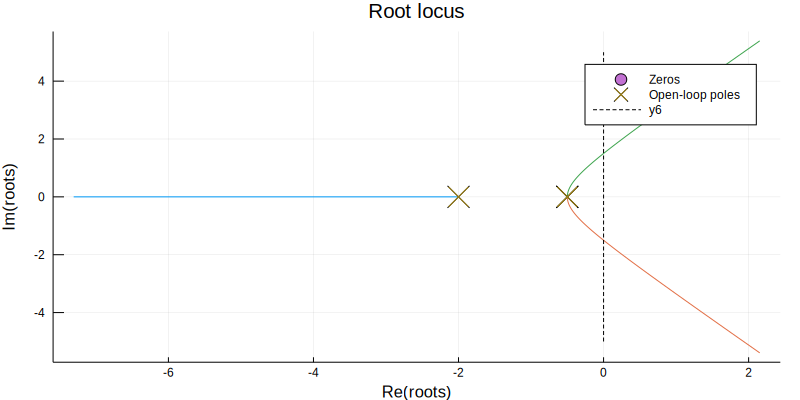

In [6]:
rlocusplot(P); plot!([0,0],[-5,5],l=(:dash,:black))

Let's step up the game and control the system with a PID controller. Use [Ziegler–Nichols frequency method](https://en.wikipedia.org/wiki/Ziegler%E2%80%93Nichols_method) to tune a PID controller for the system. The PID controller is implemented in [parallell form](https://github.com/JuliaControl/ControlSystems.jl/blob/d8fc3d8e60a5c7e71cac5ce21f9df777201cecd6/src/pid_design.jl#L3-L9). 
To find the critical gain, we can check at which frequency the above system self oscillates, or compute this gain numerically as done below.

In [7]:
using Roots
fzero(K->maximum(real.(pole(feedback(P,tf(K))))), 1, 20)

12.49999999999996

### **Question 4**
Find a controller tuning using Ziegler–Nichols (ZN) frequency method.

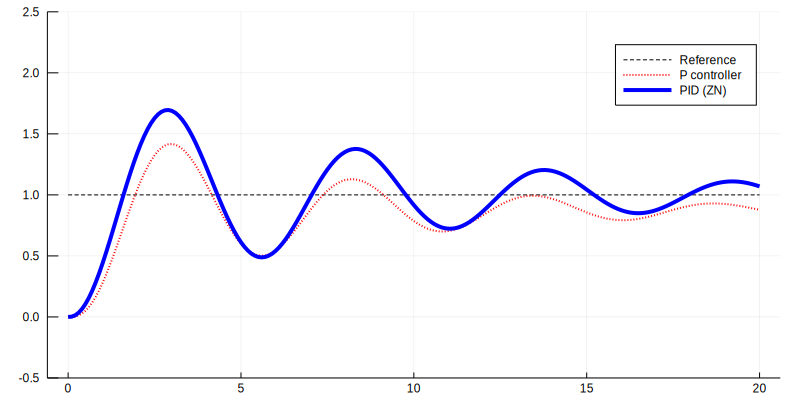

In [8]:
conditions  = [(x,y,r) -> true]
Tf          = 20              # Length of experiments (seconds)
t           = 0:h:Tf          # Time vector
tspan       = (0.0,Tf)
x0          = [0.,0,0]
filter      = tf([1],[1/20,1])

# Controller parameters computed by the ZN method
kp = ... #<-- Insert gain here
ki = ... #<-- Insert gain here
kd = ... #<-- Insert gain here

con_ZN = pid(kp=kp, ki=ki, kd=kd)*filter
sim_ZN = GainSchedulingSimulator(Ps, reference, [con_ZN], conditions, feedforward=[0])
sol_ZN = solve(sim_ZN, x0, tspan, Tsit5()) 

plot(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,2.5), subplot=1)
plot!(t, sim_P.y(sol_P, t)[:], lab="P controller",l=(:red,:dot,2.0))
plot!(t, sim_ZN.y(sol_ZN, t)[:], lab="PID (ZN)",l=(:blue,4.0))

### **Question 5**
Can you find a better tuning manually than the controller tuned with ZN? What would you say constitutes a good controller tuning?

In [9]:
conditions  = [(x,y,r) -> true]
Tf          = 20              # Length of experiments (seconds)
t           = 0:h:Tf          # Time vector
tspan       = (0.0,Tf)
x0          = [0.,0,0]
feedforward = [0]

@manipulate for kp = LinRange(0,10,50),ki = LinRange(0,5,50),kd = LinRange(0,20,50)
    
    global sim_MAN, sol_MAN, con_MAN
    
    filter = tf([1],[1/20,1])
    con_MAN = pid(kp=kp, ki=ki, kd=kd)*filter
    sim_MAN = GainSchedulingSimulator(Ps, reference, [con_MAN], conditions, feedforward=feedforward)
    sol_MAN  = solve(sim_MAN, x0, tspan, Tsit5())
    
    plot(t, reference.(0,t), lab="Reference", l=(:dash, :black), ylims=(-0.1,1.5))
    plot!(t, sim_P.y(sol_P, t)[:], lab="P controller",l=(:red,:dot,2.0))
    plot!(t, sim_ZN.y(sol_ZN, t)[:], lab="PID (ZN)",l=(:blue,:dot,2.0))
    plot!(t, sim_MAN.y(sol_MAN, t)[:], lab="PID (manual)",l=(:green,4.0))
    
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:kp=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.204082", "0.408163", "0.612245", "0.816327", "1.02041", "1.22449", "1.42857", "1.63265", "1.83673"  …  "8.16327", "8.36735", "8.57143", "8.77551", "8.97959", "9.18367", "9.38776", "9.59184", "9.79592", "10.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"4.89796",:value=>Observable{Float64} with 2 listeners. Value:
4.89796), Observable{Float64} with 2 listeners. Value:
4.89796, Scope("knockout-component-cbcd0d79-62cd-4421-9090-26636924fdee", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["kp"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.204082", "0.408163", "0.612245", "0.816327", "1.02041", "1.22449", "1.42857", "1.63265", "1.83673"  …  "8.16327", "8.36735", "8.57143", "8.77551", "8.97959", "9.18367", "9.38776", "9.59184", "9.79592", "10.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"4.89796", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        

## Exercise 2 - Auto tuning in Julia
Even with interactive tools such as the ones that you have been using in this lab, tuning a PID controller by hand can be difficult. A basic control course teaches us how to design a PID controller based on, e.g., pole placement. In the code below, we will instead formulate an optimization problem where we optimize a cost function $J(k_p,k_i,k_d)$ based on the step response of the closed-loop system
$$J(k_p,k_i,k_d) \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |r(t)-y(t)| dt \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |e(t)|dt$$

In [10]:
using NLopt, ForwardDiff
p              = [0.1,0.1,0.1] # Initial guess [kp, ki, kd]
Kpid(kp,ki,kd) = pid(kp=kp, ki=ki, kd=kd)
Kpid(p)        = K(p...)

function timedomain(p)
    C     = Kpid(p[1], p[2], p[3])
    L     = feedback(P*C) |> ss
    s     = Simulator(L, (x,t) -> [1]) # Sim. unit step load disturbance
    ty    = eltype(p) # So that all inputs to solve have same numerical type (ForwardDiff.Dual)
    x0    = zeros(L.nx) .|> ty
    tspan = (ty(0.),ty(Tf))
    sol   = solve(s, x0, tspan)
    y     = L.C*sol(t) # y = C*x
    y
end

function costfun(p)
    y = timedomain(p)
    mean(abs,1 .- y) # ~ Integrated absolute error IAE
end

f_cfg = ForwardDiff.GradientConfig(costfun, p)

function f(p::Vector, grad::Vector)
    if length(grad) > 0
        grad .= ForwardDiff.gradient(costfun,p,f_cfg)
    end
    costfun(p)
end

function runopt(p; f_tol = 1e-5, x_tol = 1e-3)
    opt = Opt(:LD_AUGLAG, 3)
    lower_bounds!(opt, 1e-6ones(3))
    xtol_rel!(opt, x_tol)
    ftol_rel!(opt, f_tol)

    min_objective!(opt, f)
    NLopt.optimize(opt, p)[2]
end

@info "Starting Optimization"
@time p = runopt(p, x_tol=1e-6)
y = timedomain(p)
plot(t,y')
println(p)

┌ Info: Starting Optimization
└ @ Main In[10]:42


 12.929898 seconds (29.07 M allocations: 1.439 GiB, 7.72% gc time)
[18.3209, 4.58175, 34.3151]


### **Question 6**
Looking at the plot below, how would you say that the optimization based tuning compares to the one that you found using the Ziegler-Nichol's frequency method or manual tuning?

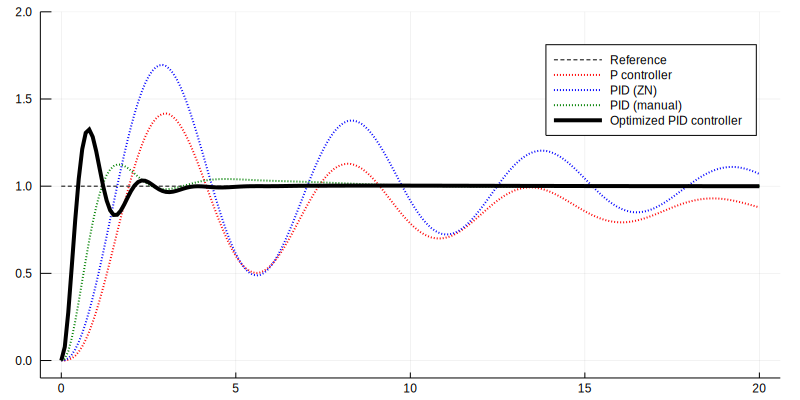

In [11]:
plot(t, reference.(0,t), lab="Reference", l=(:dash, :black), ylims=(-0.1,2))
plot!(t, sim_P.y(sol_P, t)[:], lab="P controller",l=(:red,:dot,2.0))
plot!(t, sim_ZN.y(sol_ZN, t)[:], lab="PID (ZN)",l=(:blue,:dot,2.0))
plot!(t, sim_MAN.y(sol_MAN, t)[:], lab="PID (manual)",l=(:green,:dot,2.0))
plot!(t,timedomain(p)', lab="Optimized PID controller",l=(:black,4.0), )

In order for a controller to be considered good, it need not only generate a suitable complementary sensitivity function from reference to output, i.e. $T(s)=P(s)C(s)(1+P(s)C(s))^{-1}$, but we also need to make sure that the other three members of the gang of four are reasonable. If you are unfamiliar with the gang of four, there is a nice discussion on the sensitivity funcitons [here](https://www.cds.caltech.edu/~murray/courses/cds101/fa02/caltech/astrom-ch5.pdf). Looking at the sensitivity fuinctions of the closed loop system when using the optimized controller, we seem to have ended up a quite aggressive controller at the cost of robustness. 

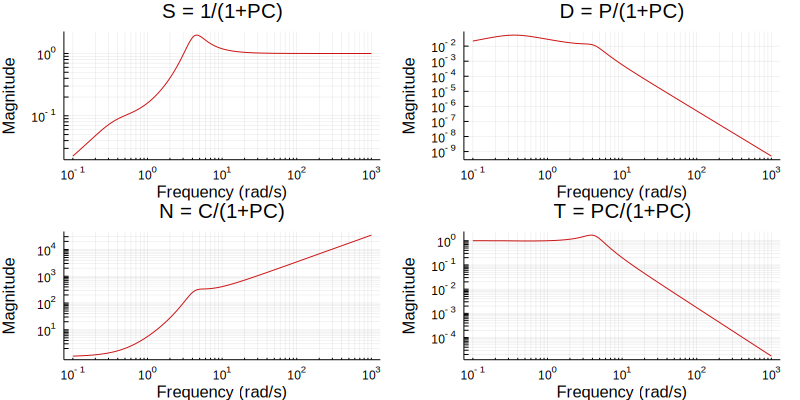

In [12]:
con_OPT   = Kpid(p...)
gangoffourplot(P,con_OPT, exp10.(LinRange(-1,3,500)), legend=false)

To combat this, we can add bounds on the maximum value of the sensitivity functions. We redefine our optimization objective in the time domain, such that we again mininize
$$
J(k_p,k_i,k_d) \quad=\quad \dfrac{1}{T_f}\int_0^{T_f} |e(t)|dt
$$
but now we add a the constraints
$$
abs(S(i\omega_i))) \leq M_S \qquad \forall \omega_i\in \Omega
$$
$$
abs(T(i\omega_i))) \leq M_T\qquad \forall \omega_i\in \Omega
$$
for some $M_S,M_T>1$ and $\Omega=\{\omega_1,...,\omega_N\}$ being a set of points in the frequency domain (here 150 points on the interval 0.1 to 100, equidistant in the standard logaritm). The code below finds the optimal controller tuning and allows you to adjust the weights $M_S,M_T$ using two sliders.


In [13]:
Ω  = exp10.(LinRange(-1,2,150))
p0 = [0.1,0.1,0.1]
function freqdomain(p)
    C     = Kpid(p[1], p[2], p[3])
    S     = 1/(1+P*C) # Sensitivity fun
    T     = tf(1.) - S# Comp. Sensitivity fun
    Sw    = vec(bode(S,Ω)[1]) # Freq. domain constraints
    Tw    = vec(bode(T,Ω)[1]) # Freq. domain constraints
    Sw,Tw
end

@manipulate for Ms = LinRange(1.1,2,20), Mt = LinRange(1.1,2,20)
    global p0, p
    p = p0
    function constraintfun(p)
        Sw,Tw = freqdomain(p)
        [maximum(Sw)-Ms; maximum(Tw)-Mt]
    end

    g_cfg = ForwardDiff.JacobianConfig(constraintfun, p)

    function c(result, p::Vector, grad)
        if length(grad) > 0
            grad .= ForwardDiff.jacobian(constraintfun,p,g_cfg)'
        end
        result .= constraintfun(p)
    end

    function runopt(p; f_tol = 1e-5, x_tol = 1e-3, c_tol = 1e-8)
        opt = Opt(:LD_SLSQP, 3)
        lower_bounds!(opt, 1e-6ones(3))
        xtol_rel!(opt, x_tol)
        ftol_rel!(opt, f_tol)

        min_objective!(opt, f)
        inequality_constraint!(opt, c, c_tol*ones(2))
        NLopt.optimize(opt, p)[2]
    end


    p = runopt(p, x_tol=1e-6)
    y = timedomain(p)
    Sw,Tw = freqdomain(p)
    plot(t,y', layout=2, show=false)
    plot!(Ω, [Sw Tw] , lab=["Sw" "Tw"], subplot=2, xscale=:log10, yscale=:log10)
    plot!([Ω[1],Ω[end]], [Ms,Ms], c = :black, l=:dash, subplot=2, lab="Ms")
    plot!([Ω[1],Ω[end]], [Mt,Mt], c = :purple, l=:dash, subplot=2, lab="Mt", ylims=(0.01,3))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:Ms=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
10,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["1.1", "1.14737", "1.19474", "1.24211", "1.28947", "1.33684", "1.38421", "1.43158", "1.47895", "1.52632", "1.57368", "1.62105", "1.66842", "1.71579", "1.76316", "1.81053", "1.85789", "1.90526", "1.95263", "2.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"1.52632",:value=>Observable{Float64} with 2 listeners. Value:
1.52632), Observable{Float64} with 2 listeners. Value:
1.52632, Scope("knockout-component-6a3c9da0-b62a-48a8-93e5-5b85ffd23772", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["Ms"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>20,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["1.1", "1.14737", "1.19474", "1.24211", "1.28947", "1.33684", "1.38421", "1.43158", "1.47895", "1.52632", "1.57368", "1.62105", "1.66842", "1.71579", "1.76316", "1.81053", "1.85789", "1.90526", "1.95263", "2.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"1.52632", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
10, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    v

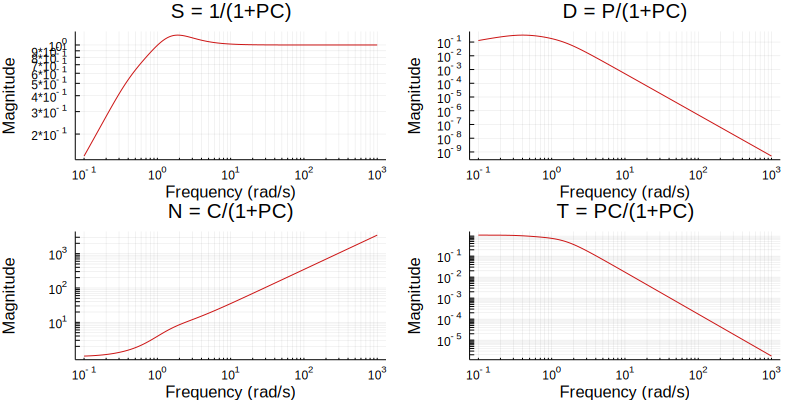

In [14]:
con_OPT  = Kpid(p...)
gangoffourplot(P,con_OPT, exp10.(LinRange(-1,3,500)), legend=false)

### **Question 7**
In which sense does introduction of a penalty on sensitivity function $S(s)$ make the controller more robust? Are there any other sensitivity functions that we need to be worried about?

In the plot below, you will see the step response of the optimized PID controller as compared to all the controllers generated up until this point in the lab session.

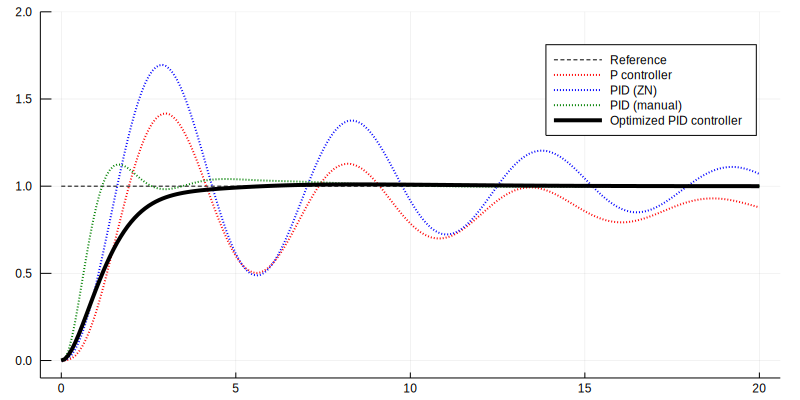

In [15]:
plot(t, reference.(0,t), lab="Reference", l=(:dash, :black), ylims=(-0.1,2.0))
plot!(t, sim_P.y(sol_P, t)[:], lab="P controller",l=(:red,:dot,2.0))
plot!(t, sim_ZN.y(sol_ZN, t)[:], lab="PID (ZN)",l=(:blue,:dot,2.0))
plot!(t, sim_MAN.y(sol_MAN, t)[:], lab="PID (manual)",l=(:green,:dot,2.0))
plot!(t,timedomain(p)', lab="Optimized PID controller",l=(:black,4.0), )

## Exercise 3 - Gain Scheduling 

We now introduce gain scheduling. The following code defines two controllers and a vector of conditions that determine when to switch between the controllers. The switching conditions are allowed to be arbitrary functions of the state $x$, the output $y$ or the reference $r$. The template below implements a schedule based on a simple threshold value on the output, $y=th$. Experiment with the controller parameters of the two controllers and the scheduling signal. 

### **Question 8**
Which signals could be suitable for gain scheduling?

### **Question 9**
Can you implement a controller which is both faster and has better damping than your best controller from the previous task?

In [17]:
Tf             = 50                 # Length of experiments (seconds)
t              = 0:h:Tf             # Time vector
reference(x,t) = t < Tf/2 ? 0. : 1. # Reference generator (step function)
s              = Simulator(Ps)
x0             = [0.,0,5/2]         # Initial state
tspan          = (0.0,Tf)

feedforward = Float64[0,0]
@manipulate for kp1 = LinRange(0,20,50),ki1 = LinRange(0,5,50),kp2 = LinRange(0,20,50),ki2 = LinRange(0,5,50),kd  = LinRange(0,20,50),th  = LinRange(0,1,20)

    plot(t, [reference(x0,tt) for tt in t], lab="Reference", l=(:dash, :black))
    
    # Definition of the the gain scheduled controller
    filter = tf([1],[1/20,1])
    controllers  = [pid(kp=kp1, ki=ki1, kd=kd)*filter, pid(kp=kp2, ki=ki2, kd=kd)*filter]
    conditions   = [(x,y,r) -> abs(y[1]-r[1]) < th, (x,y,r) -> abs(y[1]-r[1]) >= th]
    gs           = GainSchedulingSimulator(Ps, reference, controllers, conditions, feedforward=feedforward)
    solGs        = solve(gs, x0, tspan, Tsit5())
    
    plot!(t, gs.y(solGs, t)[:], lab="Gain scheduled controller", ylims=(-1,2.5),l=(:blue, 2.0))
    plot!([tspan...], [th, th], lab="Threshold", l=(:dash, :red), legend=:bottomright)
    
    # Definition of the manual and optimized controlles
    sim_MAN       = GainSchedulingSimulator(Ps, reference, [con_MAN], [(x,y,r)->y[1]*0 <1], feedforward=[0])
    sol_MAN       = solve(sim_MAN, x0, tspan, Tsit5())
    plot!(t, sim_MAN.y(sol_MAN, t)[:], lab="PID (manual)", ylims=(-1,2.5), l=(:green,:dot,2.0))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:kp1=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"9.79592",:value=>Observable{Float64} with 2 listeners. Value:
9.79592), Observable{Float64} with 2 listeners. Value:
9.79592, Scope("knockout-component-694b5f75-5ddd-4154-b8bb-8fed4f07f2b6", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["kp1"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"9.79592", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n 

Okay, now it's time to make it a bit harder. We now add a nonlinearity, $g(u)$ to the process input. Let

$$
g(u)=\begin{cases}
u = u_i^2 \qquad \text{if}\quad  u_i > 0\\
u = 0.1u_i \quad \text{otherwise}
\end{cases}
$$

as depicted in the plot below.

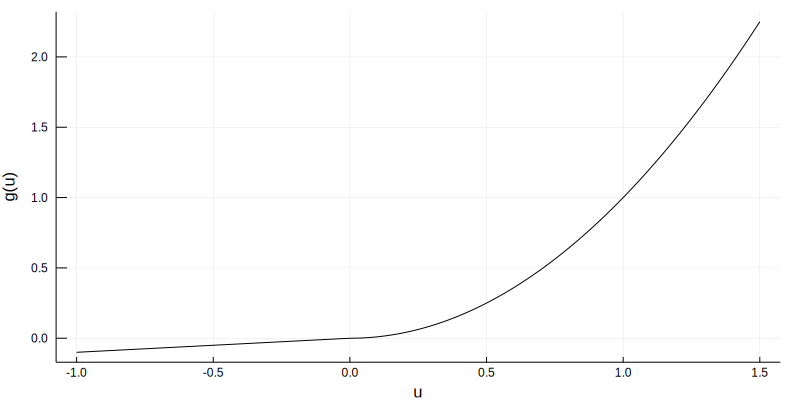

In [18]:
nonlinearity(u) = u < 0 ? 0.1u : u^2
plot(LinRange(-1,1.5,200),nonlinearity, lab="", c=:black, xlabel="u", ylabel="g(u)")

### **Question 10**
Try to manually retune a PID-controller for the system with the input nonlinearity. Is it possible to achieve an good result?

In [20]:
Tf             = 75.
tspan          = (0.,Tf)
t              = 0:h:Tf
x0             = [0,0,5/2]
conditions     = [(x,y,r) -> true]
reference(x,t) = t < Tf/2 ? 0. : 1.
feedforward    = Float64[1]
@manipulate for kp = LinRange(0,3,50), ki = LinRange(0,3,50), kd = LinRange(0,3,50)
    global con_MAN
    con_MAN = pid(kp=kp, ki=ki, kd=kd)*filter
    global gs, sol2
    gs    = GainSchedulingSimulator(Ps, reference, [con_MAN], conditions,
        inputfun=(u,t)->nonlinearity.(u), feedforward=feedforward)
    sol2  = solve(gs, x0, tspan, Tsit5())
    plot(t, gs.y(sol2, t)[:], lab="PID (manual)", l=(:green, 2.0))
    plot!(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,2.))
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:kp=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.0612245", "0.122449", "0.183673", "0.244898", "0.306122", "0.367347", "0.428571", "0.489796", "0.55102"  …  "2.44898", "2.5102", "2.57143", "2.63265", "2.69388", "2.7551", "2.81633", "2.87755", "2.93878", "3.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"1.46939",:value=>Observable{Float64} with 2 listeners. Value:
1.46939), Observable{Float64} with 2 listeners. Value:
1.46939, Scope("knockout-component-394f74b3-a209-413d-8b9e-8c186e8cb90c", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["kp"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.0612245", "0.122449", "0.183673", "0.244898", "0.306122", "0.367347", "0.428571", "0.489796", "0.55102"  …  "2.44898", "2.5102", "2.57143", "2.63265", "2.69388", "2.7551", "2.81633", "2.87755", "2.93878", "3.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"1.46939", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n    

Once again, we try a controller with gain scheduling. The left plot displays the control signal of the two controllers.

In [22]:
Tf    = 75.
tspan = (0.,Tf)
t     = 0:h:Tf
feedforward = Float64[0,0]

reference(x,t) = t < Tf÷3 ? 0. : 1.
disturbance(x,t) = 0.
disturbance(x,t) = t < 2Tf÷3 ? 0. : -1.   #<----------- Uncomment to apply the load disturbance

@manipulate for kp1 = LinRange(0,20,50),ki1 = LinRange(1e-5,8,50),kd1 = LinRange(1e-5,10,50),kp2 = LinRange(0,10,50),ki2 = LinRange(1e-5,8,50),kd2 = LinRange(1e-5,8,50),th  = LinRange(0,1,20)

    gs    = GainSchedulingSimulator(Ps, reference, [con_MAN], [(x,y,r) -> true],
        inputfun=(u,t)->nonlinearity.(u) .+ disturbance(0,t))
    sol2  = solve(gs, x0, tspan, Tsit5())
    plot(t, gs.y(sol2, t)[:], lab="PID (manual)", l=(:green, 2.0), layout=2)

    controllers  = ss.([pid(kp=kp1, ki=ki1, kd=kd1)*filter,
                        pid(kp=kp2, ki=ki2, kd=kd2)*filter])
    conditions   = [(x,y,r) -> y[1] < th, 
                    (x,y,r) -> y[1] >= th]
    gs2          = GainSchedulingSimulator(Ps, reference, controllers, conditions,
                        inputfun=(u,t)->nonlinearity.(u) .+ disturbance(0,t), feedforward=feedforward)
    sol3         = solve(gs2, x0, tspan, Tsit5(), reltol=1e-4, abstol=1e-4)

    # Plotting
    U  = hcat(sol3.u...)
    x  = [[u[1],u[2],u[3]] for u in sol3.u]
    u1 = controllers[1].C*U[3:4,:] + controllers[1].D.*hcat((gs2.e.(x, sol3.t))...)
    u2 = controllers[2].C*U[5:6,:] + controllers[2].D.*hcat((gs2.e.(x, sol3.t))...)
    plot!(t, gs2.y(sol3, t)[:], lab="Gain scheduled controller", ylims=(-1.5,3), subplot=1, c=:blue)
    plot!(t, reference.(0,t), lab="Reference", l=(:dash,:black), subplot=1)
    plot!(t, disturbance.(0,t), lab="Disturbance", l=(:dash,:blue), subplot=1)
    plot!([tspan...], [th, th], lab="Threshold", l=(:dash,:red), subplot=1)
    plot!(u1[:], lab="u_1", l=(:blue,2.0),subplot=2)
    plot!(u2[:], lab="u_2", l=(:red,2.0),subplot=2)
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:kp1=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"9.79592",:value=>Observable{Float64} with 2 listeners. Value:
9.79592), Observable{Float64} with 2 listeners. Value:
9.79592, Scope("knockout-component-149e6b48-c372-441a-aee7-6ac8b8729fd1", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["kp1"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.408163", "0.816327", "1.22449", "1.63265", "2.04082", "2.44898", "2.85714", "3.26531", "3.67347"  …  "16.3265", "16.7347", "17.1429", "17.551", "17.9592", "18.3673", "18.7755", "19.1837", "19.5918", "20.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"9.79592", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n 

### **Question 11**
Can you manage to get a gain scheduled controller that is better than the simple PID controller?

### **Question 12**
Add an input disturbance by uncommenting "# t < 2Tf÷3 ? 0. : -1.". Does your scheduling still work as well?

### **Question 13**
Remove the input disturbance and try setting $k_i$ and $k_d$ to zero to use two proportional controllers and play around with the threshold value. Can you manage to get the controller stuck in the middle of the step response?

To get a better feeling for the practicalities of gain scheduling, you'll be asked to implement a simple gain scheduled controller with interpolation below. We consider the same process and nonlinearity as above, but this time we'll implement two P-controllers and an interpolation region.

### **Question 14**
Define two threshold values $t_1$ and $t_2$, between which you interpolate the value of the control signal requested by the two controllers. Figure out the equations for linear interpolation between the thresholds, i.e., if you have two candidate control signals $u_1,u_2$, what should the control signal to output in the following cases, where $p$ is the scheduling signal?

1. $p < t_1$
2. $t_1 \leq p < t_2$
3. $p \geq t_2$

Implement the controller logic below, and add sliders for $t_1$ and $t_2$ to make experimentation faster.


In [107]:
Tf             = 50                 # Length of experiments (seconds)
t              = 0:h:Tf             # Time vector
reference(x,t) = t < Tf÷3 ? 0. : 1. # Reference generator (step function)
s              = Simulator(Ps)
x0             = [0.,0,5/2]         # Initial state
tspan          = (0.0,Tf)

@manipulate for K1 = LinRange(0,10,50), K2 = LinRange(0,5,50), t1 = LinRange(0,3,50), t2 = LinRange(0,3,50)

    function controller(x,t)
        y  = Ps.C*x # Form measurement signal
        e  = 2*reference(x,t) .- y
        u1 = K1*e
        u2 = K2*e
        
        #p=... #<-- select some p and 
        #u=... #<-- Implement controller logic 

        return u 
    end
    
    s    = Simulator(Ps,(u->nonlinearity.(u)) ∘ controller)
    solg = solve(s, x0, tspan, Tsit5()) # Simulate the system
    plot(t, s.y(solg, t)[:], lab="GS controller", layout=2, subplot=1)
    plot!(t, reference.(0,t), lab="Reference", l=:dash, c=:black, ylims=(-0.5,2.5), subplot=1)
    plot!(t, [controller(solg(t),t)[] for t ∈ t], lab="u", ylims=(-8,8), subplot=2)
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:K1=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
25,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "0.204082", "0.408163", "0.612245", "0.816327", "1.02041", "1.22449", "1.42857", "1.63265", "1.83673"  …  "8.16327", "8.36735", "8.57143", "8.77551", "8.97959", "9.18367", "9.38776", "9.59184", "9.79592", "10.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"4.89796",:value=>Observable{Float64} with 2 listeners. Value:
4.89796), Observable{Float64} with 2 listeners. Value:
4.89796, Scope("knockout-component-8e37e335-6198-4f25-bcad-f24a08f3d8a3", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["K1"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-left")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>50,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-center")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row-right")), 1)], Dict{Symbol,Any}(:attributes=>Dict("class"=>"interact-flex-row")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "0.204082", "0.408163", "0.612245", "0.816327", "1.02041", "1.22449", "1.42857", "1.63265", "1.83673"  …  "8.16327", "8.36735", "8.57143", "8.77551", "8.97959", "9.18367", "9.38776", "9.59184", "9.79592", "10.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"4.89796", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Any["knockout"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/var/tmp/greiff/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/all.js", "/var/tmp/greiff/packages/InteractBase/3SqBl/src/../assets/style.css", "/var/tmp/greiff/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        


Tuning a gain schedule and the parameters of the scheduled controllers can become very tedious. Even more so it the process time constant is long and one does not have a simulator. A more systematic apporach is to linearize the system around two different operating points and design a well-damped controller for both linear systems. One then chooses a threshold somewhere between the operating points, either in the control signal space, output space or state space. One can alternatively use the autotuning approach to tune the controller based on several different responses, to both reference changes and load disturbances.